In [1]:
import os, sys
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(30)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.12:59191 Dashboard: http://10.148.1.12:8787/status,Cluster Workers: 58 Cores: 232 Memory: 2900.00 GB


--- 

# automatic rewriting of all variables (for spectral calculations)

# transposed data: (i,j,time), 1 file per face, time windows

In [5]:
face_60 = [1, 2, 4, 5, 7, 8, 10, 11]
face_60 = [1]

print(face_60)

[1]


In [ ]:
V = ['Eta']

transpose = True # False untested

if transpose:
    Nt = 24*10*6 # time windows to consider
    out_dir = scratch+'/mit_nc_new/'
    #out_dir = '/home1/pharos/othr/xyu/mit_nc/'
    fsize_bound = 15*1e9*6
else:
    Nt = 1
    out_dir = scratch+'/mit_nc/'    
    fsize_bound = 60*1e6    

for v in V:
    #
    data_dir = root_data_dir+v+'/'
    iters, time = get_iters_time(v, data_dir, delta_t=25.)
    #
    it = np.arange(time.size/Nt-1).astype(int)*Nt # for the whole time series
    it = np.arange(1).astype(int)*Nt # for certain number of time series
    assert it[-1]+Nt<time.size
    #
    p = 'C'
    vdrop = ['XC','YC','Depth','rA']
    if v is 'SSU':
        p = 'W'
        vdrop = ['dxC','dyG','rAw']        
    elif v is 'SSV':
        p = 'S'
        vdrop = ['dxG','dyC','rAs']      
    #
    ds = get_compressed_data(v, data_dir, grid_dir, iters=iters, time=time, client=client, point=p)
    #ds = ds.chunk({'face': 1})
    #
#   for face in range(ds['face'].size):    
    for face in face_60:   
        for i, t in enumerate(it):
            #
            file_out = out_dir+'/%s_f%02d_t%02d.nc'%(v,face,i)
            if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
                dv = ds[v].isel(time=slice(1512,1512+Nt), face=face)                    ######### starting from 1512!! ########
                # should store grid data independantly in a single file
                dv = dv.drop(['XC','YC','Depth','rA']).to_dataset()
                #
                if transpose:
                    dv = dv.chunk({'time': dv['time'].size, 'i': 432, 'j': 432})
                    dv = dv.transpose('i','j','time')
                    chunksizes = [432, 432, dv['time'].size]
                else:
                    dv = dv.chunk({'i': 432, 'j': 432})
                    chunksizes = [1, 432, 432]
                #print(dv)
                #
                while True:
                    try:
                        %time dv.to_netcdf(file_out, mode='w', unlimited_dims=['time'], \
                                           encoding={'Eta': {'chunksizes': chunksizes}})
                    except:
                        print('Failure')
                    if os.path.isfile(file_out) and os.path.getsize(file_out)>fsize_bound:
                        #
                        print('face=%d / i=%d'%(face,i))
                        break
            else:
                print('face=%d / i=%d - allready processed'%(face,i))

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:336: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:249: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler inst

--- 

# standard data layout: (face, j, i), 1 file per time (for movies)

In [5]:
V = ['SSU']

Nt = 1
out_dir = '/home1/scratch/xyu/mit_nc_t/'  
print(out_dir)

fsize_bound = 13*60*1e6

for v in V:
    #
    data_dir = root_data_dir+v+'/'
    iters, time = get_iters_time(v, data_dir, delta_t=25.)
    #
    it = np.arange(time.size/Nt-1).astype(int)*Nt
    #it = np.arange(1512,1572).astype(int)*Nt # tmp
    it = np.arange(0,10).astype(int)*Nt # tmp
    

/home1/scratch/xyu/mit_nc_t/


In [6]:
print(iters)

<xarray.DataArray (time: 8785)>
array([ 228096,  228240,  228384, ..., 1492704, 1492848, 1492992])
Coordinates:
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...


In [7]:
print(time)

<xarray.DataArray (iters: 8785)>
array([ 5702400.,  5706000.,  5709600., ..., 37317600., 37321200., 37324800.])
Coordinates:
  * iters    (iters) int64 228096 228240 228384 228528 228672 228816 228960 ...


### iter 228100 (where uvts starts) matches with the 1512th data

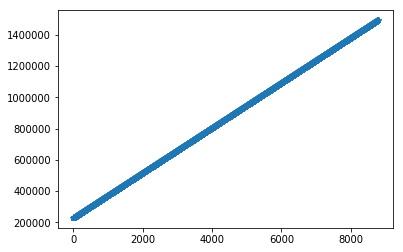

In [8]:
plt.plot(iters,'-*')
#plt.axis([1510, 1520, 228096, 228240])

In [ ]:
#V = ['Eta', 'SST', 'SSS', 'SSU', 'SSV']
V = ['Eta']

Nt = 1
#out_dir = datawork+'/mit_nc/'
out_dir = scratch+'/mit_nc_t/'    
fsize_bound = 13*60*1e6

for v in V:
    #
    data_dir = root_data_dir+v+'/'
    iters, time = get_iters_time(v, data_dir, delta_t=25.)
    #
    #it = np.arange(time.size/Nt-1).astype(int)*Nt
    it = np.arange(1512,2232).astype(int)*Nt # tmp

    assert it[-1]+Nt<time.size
    #
    p = 'C'
    #vdrop = ['XC','YC','Depth','rA']
    if v is 'SSU':
        p = 'W'
        vdrop = ['dxC','dyG','rAw']        
    elif v is 'SSV':
        p = 'S'
        vdrop = ['dxG','dyC','rAs']        
    #
    ds = get_compressed_data(v, data_dir, grid_dir, iters=iters, time=time, client=client, point=p)
    #ds = ds.chunk({'face': 1})
    #
    for i, t in enumerate(it):
        #
        file_out = out_dir+'/%s_t%04d.nc'%(v,i)
        if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
            dv = ds[v].isel(time=slice(t,t+Nt)) 
            # should store grid data independantly in a single file
            #dv = dv.drop(vdrop).to_dataset()
            dv = dv.to_dataset()
            
            while True:
                try:
                    %time dv.to_netcdf(file_out, mode='w')                    
                except:
                    print('Failure')
                if os.path.isfile(file_out) and os.path.getsize(file_out) > fsize_bound:
                    #
                    print('i=%d, iter=%d'%(i, iters[i].values))
                    break
        else:
            print('i=%d, iter=%d - allready processed'%(i, iters[i].values))

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:336: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:249: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [ ]:
V = ['SST']
out_dir = '/home1/scratch/xyu/mit_nc/'  
Nt = 1

for v in V:
    #
    data_dir = root_data_dir+v+'/'
    iters, time = get_iters_time(v, data_dir, delta_t=25.)
    it = np.arange(1512,2232).astype(int)*Nt # tmp
    it = np.arange(10).astype(int)*Nt # tmp

    assert it[-1]+Nt<time.size
    #
    p = 'C'
    vdrop = ['XC','YC','Depth','rA']
    if v is 'SSU':
        p = 'W'
        vdrop = ['dxC','dyG','rAw']         
    elif v is 'SSV':
        p = 'S'
        vdrop = ['dxG','dyC','rAs']        
        #
    ds = get_compressed_data(v, data_dir, grid_dir, iters=iters, time=time, client=client, point=p)
        #      
    for i, t in enumerate(it):
        #
        file_out = out_dir+'%s_t%04d.nc'%(v,i)
        dv = ds[v].isel(time=slice(t,t+Nt)) 
        dv = dv.drop(vdrop).to_dataset()
        #dv = dv.chunk({'face': 1, 'i': 4320, 'j': 4320})
        #dv.to_zarr(file_out, mode='w')  
        %time dv.to_netcdf(file_out, mode='w')  

In [ ]:
V = ['Eta']

Nt = 1
out_dir = '/home1/scratch/xyu/mit_nc/'  
print(out_dir)

fsize_bound = 13*60*1e6

for v in V:
    #
    data_dir = root_data_dir+v+'/'
    iters, time = get_iters_time(v, data_dir, delta_t=25.)
    #
    it = np.arange(time.size/Nt-1).astype(int)*Nt
    it = np.arange(10).astype(int)*Nt # tmp
    assert it[-1]+Nt<time.size
    #
    p = 'C'
    vdrop = ['XC','YC','Depth','rA']
    if v is 'SSU':
        p = 'W'
        vdrop = ['dxC','dyG','rAw']        
    elif v is 'SSV':
        p = 'S'
        vdrop = ['dxG','dyC','rAs']        
    #
    ds = get_compressed_data(v, data_dir, grid_dir, iters=iters, time=time, client=client, point=p)
    
    #ds = ds.chunk({'face': 1})
    #
    for i, t in enumerate(it):
        #
        file_out = out_dir+'/%s_t%04d.nc'%(v,i)
        if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
            dv = ds[v].isel(time=slice(t,t+Nt)) 
            # should store grid data independantly in a single file
            dv = dv.drop(vdrop).to_dataset()
            #
            #print(dv)
            #
            while True:
                try:
                    #print(dv)
                    %time dv.to_netcdf(file_out, mode='w')                    
                except:
                    print('Failure')
                if os.path.isfile(file_out) and os.path.getsize(file_out) > fsize_bound:
                    #
                    print('i=%d, iter=%d'%(i, iters[i].values))
                    break
        else:
            print('i=%d, iter=%d - allready processed'%(i, iters[i].values))

In [16]:
cluster.scheduler.close()

<Future finished result=None>